In [140]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
OneHotEncoder,
MinMaxScaler,
PowerTransformer,
FunctionTransformer,
StandardScaler,
OrdinalEncoder

)
from sklearn.ensemble import RandomForestRegressor
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
RareLabelEncoder,
MeanEncoder,
CountFrequencyEncoder
)
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.datetime import DatetimeFeatures
import warnings

### 1. Display Settings

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
sklearn.set_config(transform_output = 'pandas')

In [5]:
warnings.filterwarnings('ignore')

### 2. Read DataSet

In [6]:
path = r'C:\Users\kishv\OneDrive\Desktop\flights-sagemaker-projects\Data\train.csv'
train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-12,Delhi,Cochin,16:00:00,21:00:00,300,1.0,No Info,6069
1,Indigo,2019-03-01,Chennai,Kolkata,14:40:00,17:05:00,145,0.0,No Info,7295
2,Spicejet,2019-06-03,Mumbai,Hyderabad,05:45:00,07:15:00,90,0.0,No Info,2753
3,Jet Airways,2019-06-03,Delhi,Cochin,21:25:00,19:00:00,1295,2.0,No Info,13292
4,Jet Airways,2019-06-06,Kolkata,Banglore,20:25:00,10:55:00,870,1.0,In-flight meal not included,10539
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-24,Banglore,New Delhi,05:45:00,10:45:00,300,1.0,In-flight meal not included,8147
636,Spicejet,2019-03-24,Chennai,Kolkata,17:45:00,20:05:00,140,0.0,No Info,5418
637,Air India,2019-03-01,Banglore,New Delhi,08:50:00,23:55:00,905,2.0,No Info,17345
638,Indigo,2019-03-24,Kolkata,Banglore,04:15:00,09:50:00,335,1.0,No Info,4150


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
x_train = train.drop(columns='price')
y_train = train.price.copy()

### 3. Tranformation Operations

In [9]:
x_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

## 3.1 airline

In [10]:
x_train.airline

0           Indigo
1           Indigo
2         Spicejet
3      Jet Airways
4      Jet Airways
          ...     
635    Jet Airways
636       Spicejet
637      Air India
638         Indigo
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [11]:
air_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='most_frequent')),
    ("grouper",RareLabelEncoder(tol=0.1, replace_with = "Other",n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore')) 
])
air_transformer.fit_transform(x_train.loc[:,['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,0.0,0.0,0.0,1.0
637,1.0,0.0,0.0,0.0,0.0
638,0.0,1.0,0.0,0.0,0.0


In [81]:
time_pipe2 = Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ('encoder',CountFrequencyEncoder()),
    ('scaler',MinMaxScaler())
    
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.167421,0.833333
1,0.000000,0.666667
2,1.000000,1.000000
3,0.099548,0.666667
4,0.099548,1.000000
...,...,...
635,1.000000,1.000000
636,0.167421,0.833333
637,1.000000,0.833333
638,1.000000,1.000000


### 5.) Column Transformer


In [136]:
column_transformer = ColumnTransformer(transformers=[
    ('air', air_transformer,['airline']),
    ('doj', doj_transformer,['date_of_journey']),
    ('location',location_transformer,['source','destination']),
    ('time',time_tranformer,['dep_time','arrival_time']),
    ("dur",duration_transformer,['duration']),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder='passthrough')
column_transformer.fit_transform(x_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf25,dur__duration_rbf50,dur__duration_rbf75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,1.0,0.882353,0.333333,0.872881,1.047597,1.039480,1,0,0.695652,0.000000,0.913043,0.000000,0.167421,0.833333,-0.371716,-0.10528,-0.107989,1.0,0,-0.669715,1.0,0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.666667,0.000000,-1.870971,-0.656516,0,1,0.608696,0.727273,0.739130,0.090909,0.000000,0.666667,-0.371716,-0.10528,-0.107989,0.0,0,-0.988389,0.0,1,0.0,1.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.823529,0.000000,0.796610,-1.870971,-0.656516,1,0,0.217391,0.818182,0.304348,0.272727,1.000000,1.000000,-0.371716,-0.10528,-0.107989,0.0,0,-1.101467,0.0,1,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.823529,0.000000,0.796610,1.047597,1.039480,1,0,0.913043,0.454545,0.826087,0.000000,0.099548,0.666667,-0.371716,-0.10528,-0.107989,2.0,1,1.375966,2.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.823529,0.500000,0.822034,-0.431894,-0.470192,1,0,0.869565,0.454545,0.434783,1.000000,0.099548,1.000000,-0.371716,-0.10528,-0.107989,2.0,0,0.502182,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.0,0.176471,1.000000,0.194915,-0.864903,-0.656516,0,1,0.217391,0.818182,0.434783,0.818182,1.000000,1.000000,-0.371716,-0.10528,-0.107989,1.0,0,-0.669715,1.0,0,1.0,0.0,0.0,1
636,0.0,0.0,0.0,0.0,1.0,0.0,0.176471,1.000000,0.194915,-1.870971,-0.656516,0,1,0.739130,0.818182,0.869565,0.090909,0.167421,0.833333,-0.371716,-0.10528,-0.107989,0.0,0,-0.998669,0.0,1,0.0,1.0,0.0,0
637,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.666667,0.000000,-0.864903,-0.656516,0,1,0.347826,0.909091,1.000000,1.000000,1.000000,0.833333,-0.371716,-0.10528,9.384683,2.0,0,0.574141,2.0,0,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.0,0.0,0.176471,1.000000,0.194915,-0.431894,-0.470192,1,0,0.173913,0.272727,0.391304,0.909091,1.000000,1.000000,-0.371716,-0.10528,-0.107989,1.0,0,-0.597757,1.0,0,0.0,1.0,0.0,0


### 4.2 date_of_journey

In [13]:
x_train.date_of_journey

0      2019-06-12
1      2019-03-01
2      2019-06-03
3      2019-06-03
4      2019-06-06
          ...    
635    2019-03-24
636    2019-03-24
637    2019-03-01
638    2019-03-24
639    2019-03-06
Name: date_of_journey, Length: 640, dtype: object

In [14]:
feature_to_extract = ['month','week','day_of_week','day_of_year']
doj_transformer = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract = feature_to_extract,yearfirst = True,format = 'mixed')),
    ('scaler',MinMaxScaler())
])
doj_transformer.fit_transform(x_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.0,0.882353,0.333333,0.872881
1,0.0,0.000000,0.666667,0.000000
2,1.0,0.823529,0.000000,0.796610
3,1.0,0.823529,0.000000,0.796610
4,1.0,0.823529,0.500000,0.822034
...,...,...,...,...
635,0.0,0.176471,1.000000,0.194915
636,0.0,0.176471,1.000000,0.194915
637,0.0,0.000000,0.666667,0.000000
638,0.0,0.176471,1.000000,0.194915


### Source and destination

In [19]:
location_subset = x_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Delhi,Cochin
1,Chennai,Kolkata
2,Mumbai,Hyderabad
3,Delhi,Cochin
4,Kolkata,Banglore
...,...,...
635,Banglore,New Delhi
636,Chennai,Kolkata
637,Banglore,New Delhi
638,Kolkata,Banglore


In [27]:
location_pipe1 = Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,replace_with='other',n_categories = 2)),
    ('encoder',MeanEncoder()),
    ('scaler',PowerTransformer())
])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.047597,1.039480
1,-1.870971,-0.656516
2,-1.870971,-0.656516
3,1.047597,1.039480
4,-0.431894,-0.470192
...,...,...
635,-0.864903,-0.656516
636,-1.870971,-0.656516
637,-0.864903,-0.656516
638,-0.431894,-0.470192


In [29]:
np.union1d(
    x_train.source.unique(),
    x_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [35]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi','Kolkata','Mumbai','New Delhi']
    return(
        X
        .assign(**{
            f"{col}_is_north": X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,0,1
637,0,1
638,1,0


In [39]:
location_transformer = FeatureUnion(transformer_list = [
    ('part1', location_pipe1), 
    ('part2',FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.047597,1.039480,1,0
1,-1.870971,-0.656516,0,1
2,-1.870971,-0.656516,1,0
3,1.047597,1.039480,1,0
4,-0.431894,-0.470192,1,0
...,...,...,...,...
635,-0.864903,-0.656516,0,1
636,-1.870971,-0.656516,0,1
637,-0.864903,-0.656516,0,1
638,-0.431894,-0.470192,1,0


### 4.4 Dept/Arrival Time

In [42]:
train.dep_time

0      16:00:00
1      14:40:00
2      05:45:00
3      21:25:00
4      20:25:00
         ...   
635    05:45:00
636    17:45:00
637    08:50:00
638    04:15:00
639    05:25:00
Name: dep_time, Length: 640, dtype: object

In [43]:
train.arrival_time

0      21:00:00
1      17:05:00
2      07:15:00
3      19:00:00
4      10:55:00
         ...   
635    10:45:00
636    20:05:00
637    23:55:00
638    09:50:00
639    19:45:00
Name: arrival_time, Length: 640, dtype: object

In [44]:
time_subset = x_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,16:00:00,21:00:00
1,14:40:00,17:05:00
2,05:45:00,07:15:00
3,21:25:00,19:00:00
4,20:25:00,10:55:00
...,...,...
635,05:45:00,10:45:00
636,17:45:00,20:05:00
637,08:50:00,23:55:00
638,04:15:00,09:50:00


In [50]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.695652,0.000000,0.913043,0.000000
1,0.608696,0.727273,0.739130,0.090909
2,0.217391,0.818182,0.304348,0.272727
3,0.913043,0.454545,0.826087,0.000000
4,0.869565,0.454545,0.434783,1.000000
...,...,...,...,...
635,0.217391,0.818182,0.434783,0.818182
636,0.739130,0.818182,0.869565,0.090909
637,0.347826,0.909091,1.000000,1.000000
638,0.173913,0.272727,0.391304,0.909091


In [79]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    return (
        X_temp
        .assign(**{
            f'{col}_part_of_day': np.select(
                [X_temp.loc[:,col].between(morning, noon, inclusive='left'),
                X_temp.loc[:,col].between(noon, eve, inclusive='left'),
                X_temp.loc[:,col].between(eve,night, inclusive='left')],
                ['morning','afternoon','evening'],
                default = 'night'
            )
            for col in columns
        })
        .drop(columns=columns)
        
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,night
1,afternoon,evening
2,morning,morning
3,night,evening
4,night,morning
...,...,...
635,morning,morning
636,evening,night
637,morning,night
638,morning,morning


In [82]:
time_tranformer = FeatureUnion(transformer_list=[
    ('part1',time_pipe1),
    ('part2',time_pipe2)
])
time_tranformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.695652,0.000000,0.913043,0.000000,0.167421,0.833333
1,0.608696,0.727273,0.739130,0.090909,0.000000,0.666667
2,0.217391,0.818182,0.304348,0.272727,1.000000,1.000000
3,0.913043,0.454545,0.826087,0.000000,0.099548,0.666667
4,0.869565,0.454545,0.434783,1.000000,0.099548,1.000000
...,...,...,...,...,...,...
635,0.217391,0.818182,0.434783,0.818182,1.000000,1.000000
636,0.739130,0.818182,0.869565,0.090909,0.167421,0.833333
637,0.347826,0.909091,1.000000,1.000000,1.000000,0.833333
638,0.173913,0.272727,0.391304,0.909091,1.000000,1.000000


### 4.5 Duration

In [84]:
x_train.duration

0       300
1       145
2        90
3      1295
4       870
       ... 
635     300
636     140
637     905
638     335
639    2300
Name: duration, Length: 640, dtype: int64

In [94]:
(
    x_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
    # .shape
)

array([[170.  ],
       [500.  ],
       [911.25]])

In [107]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self,variables = None, percentiles=[0.25,0.5,0.75],gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self,X,y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include='number').columns.to_list()

        self.reference_values_ = {
            col:(
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        return self

    def transform(self,X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf{int(percentile*100)}" for percentile in self.percentiles]
            obj=pd.DataFrame(
                data= rbf_kernel(X.loc[:,[col]],Y=self.reference_values_[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects,axis=1)

In [110]:
RBFPercentileSimilarity(percentiles=[0.4,0.8]).fit_transform(x_train)

,duration_rbf40,duration_rbf80,total_stops_rbf40,total_stops_rbf80
0,1.135971e-88,0.0,1.000000,1.000000
1,0.000000e+00,0.0,0.904837,0.904837
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,0.904837,0.904837
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,1.135971e-88,0.0,1.000000,1.000000
636,0.000000e+00,0.0,0.904837,0.904837
637,0.000000e+00,0.0,0.904837,0.904837
638,4.539993e-05,0.0,1.000000,1.000000


In [123]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [124]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [128]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(x_train.loc[:, ["duration"]])

,duration_rbf25,duration_rbf50,duration_rbf75,duration_cat,duration_over_1000,duration
0,-0.371716,-0.10528,-0.107989,1.0,0,-0.669715
1,-0.371716,-0.10528,-0.107989,0.0,0,-0.988389
2,-0.371716,-0.10528,-0.107989,0.0,0,-1.101467
3,-0.371716,-0.10528,-0.107989,2.0,1,1.375966
4,-0.371716,-0.10528,-0.107989,2.0,0,0.502182
...,...,...,...,...,...,...
635,-0.371716,-0.10528,-0.107989,1.0,0,-0.669715
636,-0.371716,-0.10528,-0.107989,0.0,0,-0.998669
637,-0.371716,-0.10528,9.384683,2.0,0,0.574141
638,-0.371716,-0.10528,-0.107989,1.0,0,-0.597757


### Total Stops

In [129]:
x_train.total_stops

0      1.0
1      0.0
2      0.0
3      2.0
4      1.0
      ... 
635    1.0
636    0.0
637    2.0
638    1.0
639    2.0
Name: total_stops, Length: 640, dtype: float64

In [131]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,0.0,1
3,2.0,0
4,1.0,0
...,...,...
635,1.0,0
636,0.0,1
637,2.0,0
638,1.0,0


### Additional Info

In [132]:
x_train.additional_info

0                          No Info
1                          No Info
2                          No Info
3                          No Info
4      In-flight meal not included
                  ...             
635    In-flight meal not included
636                        No Info
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [133]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [135]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### Feature Selection

In [141]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

### Putting altogether

In [143]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.882353,0.872881,1.047597,1.039480,1.0,-0.669715,1.0,0
1,1.0,0.0,0.0,0.000000,0.000000,-1.870971,-0.656516,0.0,-0.988389,0.0,1
2,0.0,0.0,1.0,0.823529,0.796610,-1.870971,-0.656516,0.0,-1.101467,0.0,1
3,0.0,1.0,0.0,0.823529,0.796610,1.047597,1.039480,2.0,1.375966,2.0,0
4,0.0,1.0,0.0,0.823529,0.822034,-0.431894,-0.470192,2.0,0.502182,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.176471,0.194915,-0.864903,-0.656516,1.0,-0.669715,1.0,0
636,0.0,0.0,1.0,0.176471,0.194915,-1.870971,-0.656516,0.0,-0.998669,0.0,1
637,0.0,0.0,0.0,0.000000,0.000000,-0.864903,-0.656516,2.0,0.574141,2.0,0
638,1.0,0.0,0.0,0.176471,0.194915,-0.431894,-0.470192,1.0,-0.597757,1.0,0


### Visualization

In [144]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.02266470928038644,
 'air__airline_Indigo': 0.11654087699282241,
 'air__airline_Jet Airways': 0.17216614784139572,
 'air__airline_Multiple Carriers': 0.00869748784229,
 'air__airline_Other': 0.11238150061037618,
 'doj__date_of_journey_month': 0.08733556030971372,
 'doj__date_of_journey_week': 0.11254689466872196,
 'doj__date_of_journey_day_of_week': -0.02937942960731647,
 'doj__date_of_journey_day_of_year': 0.14072352593943313,
 'location__source': 0.10244372316323798,
 'location__destination': 0.11766228349298986,
 'location__source_is_north': 0.02031621033773338,
 'location__destination_is_north': 0.02031621033773338,
 'time__dep_time_hour': -0.04306771960804823,
 'time__dep_time_minute': 0.012280547638239714,
 'time__arrival_time_hour': 0.031115766779959714,
 'time__arrival_time_minute': -0.007565892480153454,
 'time__dep_time_part_of_day': -0.03705505712201007,
 'time__arrival_time_part_of_day': -0.012573277492196278,
 'dur__duration_rbf25': 0.095291477

In [145]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': -0.04306771960804823,
 'time__dep_time_part_of_day': -0.03705505712201007,
 'dur__duration_rbf50': -0.035412064174858905,
 'doj__date_of_journey_day_of_week': -0.02937942960731647,
 'air__airline_Air India': -0.02266470928038644,
 'dur__duration_rbf75': -0.017468437042059026,
 'info__additional_info_No Info': -0.016518160669754645,
 'info__additional_info': -0.016518160669754645,
 'time__arrival_time_part_of_day': -0.012573277492196278,
 'info__additional_info_In-flight meal not included': -0.011999836991188007,
 'time__arrival_time_minute': -0.007565892480153454,
 'air__airline_Multiple Carriers': 0.00869748784229,
 'time__dep_time_minute': 0.012280547638239714,
 'info__additional_info_Other': 0.018432635585070467,
 'location__source_is_north': 0.02031621033773338,
 'location__destination_is_north': 0.02031621033773338,
 'time__arrival_time_hour': 0.031115766779959714,
 'dur__duration_over_1000': 0.06773024537802068,
 'doj__date_of_journey_month': 0.08733556030

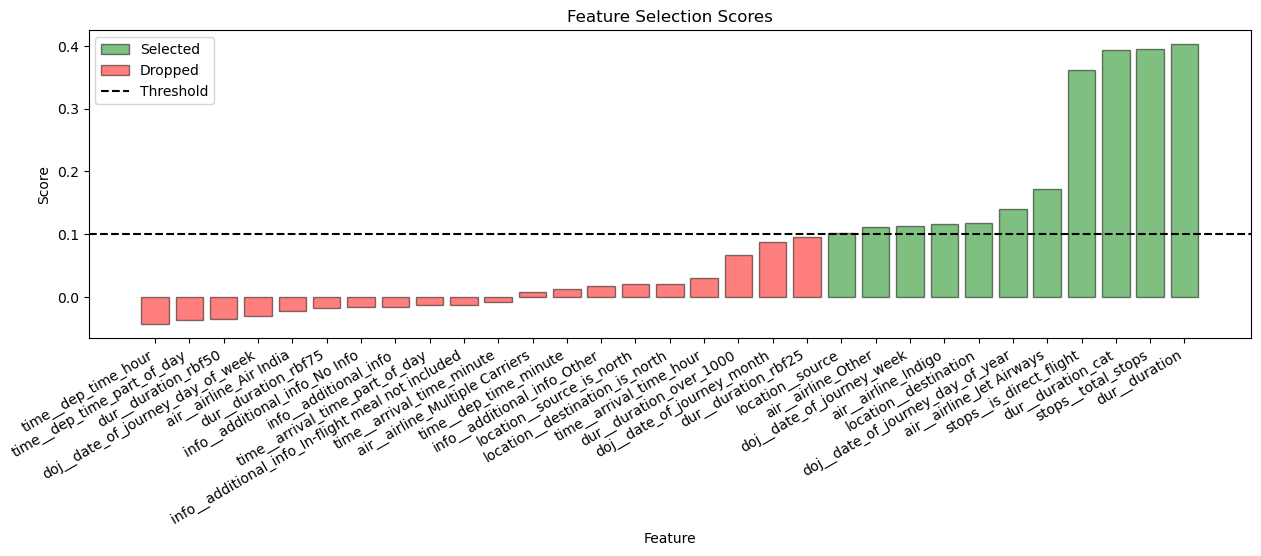

In [147]:
import matplotlib.pyplot as plt
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]
thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()